In [ ]:
%pip install mesa

In [ ]:
import mesa
print("Current version: Mesa "+ mesa.__version__)

Current version: Mesa 3.3.0


In [ ]:
import mesa
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class SolarPanel(mesa.Agent):
    """An agent that represents a solar panel and generates energy."""

    def __init__(self, model, generation_rate=1):
        """Initialize a solar panel agent.

        Args:
            model: The model instance this agent belongs to
            generation_rate: Energy generation rate per step
        """
        super().__init__(model)  # Mesa 3.0+ automatically assigns unique_id
        self.generation_rate = generation_rate
        self.energy = 0

    def step(self):
        """Generate energy each step."""
        self.energy += self.generation_rate

class Consumer(mesa.Agent):
    """An agent that represents an energy consumer."""

    def __init__(self, model, consumption_rate=1):
        """Initialize a consumer agent.

        Args:
            model: The model instance this agent belongs to
            consumption_rate: Energy consumption rate per step
        """
        super().__init__(model)  # Mesa 3.0+ automatically assigns unique_id
        self.consumption_rate = consumption_rate
        self.energy_needed = self.consumption_rate
        self.energy_consumed = 0
        self.total_energy_consumed = 0  # Track cumulative consumption

    def step(self):
        """Reset energy needs for the new step."""
        self.energy_needed = self.consumption_rate


class SolarEnergyModel(mesa.Model):
    """A model for simulating solar energy generation and consumption."""

    def __init__(self, width=10, height=10, num_solar_panels=20, num_consumers=30, seed=None):
        """Initialize the solar energy model.

        Args:
            width: The width of the grid space
            height: The height of the grid space
            num_solar_panels: The number of solar panel agents
            num_consumers: The number of consumer agents
            seed: Random seed for reproducibility
        """
        super().__init__(seed=seed)  # Mesa 3.0+ requires super().__init__()

        self.width = width
        self.height = height
        self.num_solar_panels = num_solar_panels
        self.num_consumers = num_consumers

        # Create the grid (MultiGrid allows multiple agents per cell)
        self.grid = MultiGrid(width, height, torus=True)

        # Create solar panel agents
        for _ in range(self.num_solar_panels):
            agent = SolarPanel(self, generation_rate=self.random.randint(1, 3))
            # Place agent at random position
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Create consumer agents
        for _ in range(self.num_consumers):
            agent = Consumer(self, consumption_rate=self.random.randint(1, 2))
            # Place agent at random position
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Set up data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Total Energy Generated": lambda m: sum(
                    agent.energy for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Needed": lambda m: sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                ),
                "Total Energy Consumed": lambda m: sum(
                    agent.energy_consumed for agent in m.agents_by_type[Consumer]
                ),
                "Energy Surplus": lambda m: sum(
                    agent.energy for agent in m.agents_by_type[SolarPanel]
                ) - sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                )
            },
            agent_reporters={
                "Energy": "energy",
                "Energy_Consumed": "energy_consumed"
            }
        )

    def step(self):
        """Run one step of the model."""
        # Activate all agents using Mesa 3.0+ AgentSet API
        self.agents.shuffle_do("step")

        # Calculate total energy generated and needed
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        total_generated = sum(panel.energy for panel in solar_panels)
        total_needed = sum(consumer.energy_needed for consumer in consumers)

        # Distribute energy to consumers
        available_energy = total_generated

        # Shuffle consumers for fair distribution
        consumer_list = list(consumers)
        self.random.shuffle(consumer_list)

        for consumer in consumer_list:
            if available_energy > 0:
                energy_to_consume = min(consumer.energy_needed, available_energy)
                consumer.energy_consumed = energy_to_consume
                consumer.total_energy_consumed += energy_to_consume
                consumer.energy_needed -= energy_to_consume
                available_energy -= energy_to_consume
            else:
                consumer.energy_consumed = 0

        # Reset solar panel energy for next step
        for panel in solar_panels:
            panel.energy = 0

        # Collect data
        self.datacollector.collect(self)

    def get_summary_stats(self):
        """Get summary statistics for the model."""
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        return {
            "num_solar_panels": len(solar_panels),
            "num_consumers": len(consumers),
            "total_energy_consumed": sum(c.total_energy_consumed for c in consumers),
            "avg_generation_rate": sum(p.generation_rate for p in solar_panels) / len(solar_panels),
            "avg_consumption_rate": sum(c.consumption_rate for c in consumers) / len(consumers)
        }


# Example usage and simulation
if __name__ == "__main__":
    # Model parameters
    model_params = {
        "width": 15,
        "height": 15,
        "num_solar_panels": 25,
        "num_consumers": 40,
        "seed": 42  # For reproducible results
    }

    # Create and run the model
    model = SolarEnergyModel(**model_params)

    # Run simulation
    num_steps = 100
    print(f"Running solar energy simulation for {num_steps} steps...")

    for step in range(num_steps):
        model.step()

        # Print progress every 20 steps
        if (step + 1) % 20 == 0:
            print(f"Step {step + 1}/{num_steps} completed")

    # Print final statistics
    stats = model.get_summary_stats()
    print("\n=== Simulation Results ===")
    print(f"Solar panels: {stats['num_solar_panels']}")
    print(f"Consumers: {stats['num_consumers']}")
    print(f"Total energy consumed over {num_steps} steps: {stats['total_energy_consumed']}")
    print(f"Average generation rate: {stats['avg_generation_rate']:.2f}")
    print(f"Average consumption rate: {stats['avg_consumption_rate']:.2f}")

    # Get model-level data
    model_data = model.datacollector.get_model_vars_dataframe()
    print(f"\nFinal energy surplus: {model_data['Energy Surplus'].iloc[-1]}")
    print(f"Average energy surplus: {model_data['Energy Surplus'].mean():.2f}")

Running solar energy simulation for 100 steps...
Step 20/100 completed
Step 40/100 completed
Step 60/100 completed
Step 80/100 completed
Step 100/100 completed

=== Simulation Results ===
Solar panels: 25
Consumers: 40
Total energy consumed over 100 steps: 5000
Average generation rate: 2.00
Average consumption rate: 1.48

Final energy surplus: -9
Average energy surplus: -9.00


# Task
Simulate solar energy generation and consumption using the MESA library, improve the existing code, and provide a step-by-step workflow.\


## Review the existing code

### Subtask:
Analyze the current implementation of the `SolarPanel`, `Consumer`, and `SolarEnergyModel` classes to identify areas for improvement, such as agent interactions, energy distribution logic, and data collection.


## Refine agent behavior

### Subtask:
Modify the `step` methods of the `SolarPanel` and `Consumer` agents to introduce more realistic behaviors, like energy storage for solar panels or varying consumption patterns for consumers.


**Reasoning**:
Modify the SolarPanel and Consumer agents and the SolarEnergyModel to incorporate energy storage and variable consumption patterns.



In [ ]:
import mesa
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random

class SolarPanel(mesa.Agent):
    """An agent that represents a solar panel and generates energy with storage."""

    def __init__(self, model, generation_rate=1, storage_capacity=10, year_installed=None, max_power_output=None):
        """Initialize a solar panel agent.

        Args:
            model: The model instance this agent belongs to
            generation_rate: Energy generation rate per step (can be influenced by max_power_output)
            storage_capacity: Maximum energy the panel can store
            year_installed: The year the solar system was installed
            max_power_output: The maximum power output of the system in kW
        """
        super().__init__(model)
        self.generation_rate = generation_rate # We will likely update this based on max_power_output later
        self.energy = 0
        self.storage_capacity = storage_capacity
        self.storage = 0
        self.year_installed = year_installed
        self.max_power_output = max_power_output

    def step(self):
        """Generate energy and store excess."""
        # For now, generation is still based on the initial generation_rate.
        # In a later step, we will modify this to use max_power_output and potentially other factors like time of day.
        generated = self.generation_rate
        self.energy = generated  # Energy generated in this step

        # Store excess energy, up to storage capacity
        space_in_storage = self.storage_capacity - self.storage
        stored_energy = min(generated, space_in_storage)
        self.storage += stored_energy
        self.energy -= stored_energy # Energy available for immediate use after storage

class Consumer(mesa.Agent):
    """An agent that represents an energy consumer with variable consumption."""

    def __init__(self, model, consumption_rate=1, average_daily_consumption=None, peak_usage_demand=None):
        """Initialize a consumer agent.

        Args:
            model: The model instance this agent belongs to
            consumption_rate: Base energy consumption rate per step (can be influenced by average_daily_consumption)
            average_daily_consumption: Average daily power consumption in kWh
            peak_usage_demand: Peak usage demand in kW
        """
        super().__init__(model)
        self.base_consumption_rate = consumption_rate # We will likely update this based on average_daily_consumption later
        self.consumption_rate = consumption_rate  # Current consumption rate, subject to variability
        self.energy_needed = self.consumption_rate
        self.energy_consumed = 0
        self.total_energy_consumed = 0
        self.average_daily_consumption = average_daily_consumption
        self.peak_usage_demand = peak_usage_demand


    def step(self):
        """Determine energy needs for the step with variability."""
        # Introduce variability in consumption (e.g., +/- 20%)
        # In a later step, we will modify this to use average_daily_consumption and peak_usage_demand
        variability = random.uniform(0.8, 1.2)
        self.consumption_rate = self.base_consumption_rate * variability
        self.energy_needed = self.consumption_rate


class SolarEnergyModel(mesa.Model):
    """A model for simulating solar energy generation and consumption with storage."""

    def __init__(self, width=10, height=10, num_solar_panels=20, num_consumers=30, solar_storage_capacity=10, seed=None):
        """Initialize the solar energy model.

        Args:
            width: The width of the grid space
            height: The height of the grid space
            num_solar_panels: The number of solar panel agents
            num_consumers: The number of consumer agents
            solar_storage_capacity: Storage capacity for each solar panel
            seed: Random seed for reproducibility
        """
        super().__init__(seed=seed)

        self.width = width
        self.height = height
        self.num_solar_panels = num_solar_panels
        self.num_consumers = num_consumers
        self.solar_storage_capacity = solar_storage_capacity


        # Create the grid
        self.grid = MultiGrid(width, height, torus=True)

        # Create solar panel agents
        # In a later step, we will create agents based on the loaded data
        for _ in range(self.num_solar_panels):
            agent = SolarPanel(self, generation_rate=self.random.randint(1, 3), storage_capacity=self.solar_storage_capacity)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Create consumer agents
        # In a later step, we will create agents based on the loaded data
        for _ in range(self.num_consumers):
            agent = Consumer(self, consumption_rate=self.random.randint(1, 2))
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Set up data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Total Energy Generated (Instant)": lambda m: sum(
                    agent.generation_rate for agent in m.agents_by_type[SolarPanel] # This will need updating later
                ),
                "Total Energy Stored": lambda m: sum(
                    agent.storage for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Available (Instant + Stored)": lambda m: sum(
                     agent.energy + agent.storage for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Needed": lambda m: sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                ),
                "Total Energy Consumed": lambda m: sum(
                    agent.energy_consumed for agent in m.agents_by_type[Consumer]
                ),
                "Energy Surplus (Instant + Stored)": lambda m: sum(
                    agent.energy + agent.storage for agent in m.agents_by_type[SolarPanel]
                ) - sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                )
            },
            agent_reporters={
                "Energy": "energy",
                "Storage": "storage",
                "Energy_Consumed": "energy_consumed",
                "Energy_Needed": "energy_needed",
                "Average_Daily_Consumption": "average_daily_consumption", # Added for data collection
                "Peak_Usage_Demand": "peak_usage_demand" # Added for data collection
            }
        )

    def step(self):
        """Run one step of the model with prioritized energy distribution."""
        # Agents step (generation and consumption needs are determined)
        self.agents.shuffle_do("step")

        # Calculate total energy available from generation and storage
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        total_available_energy = sum(panel.energy + panel.storage for panel in solar_panels)
        total_needed = sum(consumer.energy_needed for consumer in consumers)

        # Distribute energy to consumers based on priority (e.g., highest need first)
        available_energy_for_distribution = total_available_energy

        # Prioritize consumers by energy needed (descending order)
        consumer_list = sorted(list(consumers), key=lambda c: c.energy_needed, reverse=True)


        for consumer in consumer_list:
            if available_energy_for_distribution > 0:
                energy_to_consume = min(consumer.energy_needed, available_energy_for_distribution)
                consumer.energy_consumed = energy_to_consume
                consumer.total_energy_consumed += energy_to_consume
                consumer.energy_needed -= energy_to_consume
                available_energy_for_distribution -= energy_to_consume

                # Deduct consumed energy from solar panel storage first, then instant generation
                energy_deducted = energy_to_consume
                for panel in solar_panels:
                    deduct_from_storage = min(energy_deducted, panel.storage)
                    panel.storage -= deduct_from_storage
                    energy_deducted -= deduct_from_storage
                    if energy_deducted <= 0:
                        break

                if energy_deducted > 0:
                     for panel in solar_panels:
                        deduct_from_instant = min(energy_deducted, panel.energy)
                        panel.energy -= deduct_from_instant
                        energy_deducted -= deduct_from_instant
                        if energy_deducted <= 0:
                            break

            else:
                consumer.energy_consumed = 0

        # Collect data
        self.datacollector.collect(self)

    def get_summary_stats(self):
        """Get summary statistics for the model."""
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        return {
            "num_solar_panels": len(solar_panels),
            "num_consumers": len(consumers),
            "total_energy_consumed": sum(c.total_energy_consumed for c in consumers),
            "avg_generation_rate": sum(p.generation_rate for p in solar_panels) / len(solar_panels),
            "avg_base_consumption_rate": sum(c.base_consumption_rate for c in consumers) / len(consumers)
        }

# Example usage and simulation
if __name__ == "__main__":
    # Model parameters
    model_params = {
        "width": 15,
        "height": 15,
        "num_solar_panels": 25,
        "num_consumers": 40,
        "solar_storage_capacity": 20, # Added storage capacity parameter
        "seed": 42
    }

    # Create and run the model
    model = SolarEnergyModel(**model_params)

    # Run simulation
    num_steps = 100
    print(f"Running solar energy simulation for {num_steps} steps...")

    for step in range(num_steps):
        model.step()

        # Print progress every 20 steps
        if (step + 1) % 20 == 0:
            print(f"Step {step + 1}/{num_steps} completed")

    # Print final statistics
    stats = model.get_summary_stats()
    print("\n=== Simulation Results ===")
    print(f"Solar panels: {stats['num_solar_panels']}")
    print(f"Consumers: {stats['num_consumers']}")
    print(f"Total energy consumed over {num_steps} steps: {stats['total_energy_consumed']:.2f}")
    print(f"Average generation rate: {stats['avg_generation_rate']:.2f}")
    print(f"Average base consumption rate: {stats['avg_base_consumption_rate']:.2f}")

    # Get model-level data
    model_data = model.datacollector.get_model_vars_dataframe()
    print(f"\nFinal energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].iloc[-1]:.2f}")
    print(f"Average energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].mean():.2f}")
    print(f"Final total energy stored: {model_data['Total Energy Stored'].iloc[-1]:.2f}")

Running solar energy simulation for 100 steps...
Step 20/100 completed
Step 40/100 completed
Step 60/100 completed
Step 80/100 completed
Step 100/100 completed

=== Simulation Results ===
Solar panels: 25
Consumers: 40
Total energy consumed over 100 steps: 5000.00
Average generation rate: 2.00
Average base consumption rate: 1.48

Final energy surplus (Instant + Stored): -8.99
Average energy surplus (Instant + Stored): -8.97
Final total energy stored: 0.00


## Improve energy distribution

### Subtask:
Enhance the energy distribution mechanism in the model's `step` method to prioritize certain consumers or implement a more sophisticated energy grid simulation.


**Reasoning**:
Modify the SolarEnergyModel's step method to implement a new energy distribution logic prioritizing consumers based on their energy need.



In [ ]:
import mesa
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random

class SolarPanel(mesa.Agent):
    """An agent that represents a solar panel and generates energy with storage."""

    def __init__(self, model, generation_rate=1, storage_capacity=10):
        """Initialize a solar panel agent.

        Args:
            model: The model instance this agent belongs to
            generation_rate: Energy generation rate per step
            storage_capacity: Maximum energy the panel can store
        """
        super().__init__(model)
        self.generation_rate = generation_rate
        self.energy = 0
        self.storage_capacity = storage_capacity
        self.storage = 0

    def step(self):
        """Generate energy and store excess."""
        generated = self.generation_rate
        self.energy = generated  # Energy generated in this step

        # Store excess energy, up to storage capacity
        space_in_storage = self.storage_capacity - self.storage
        stored_energy = min(generated, space_in_storage)
        self.storage += stored_energy
        self.energy -= stored_energy # Energy available for immediate use after storage

class Consumer(mesa.Agent):
    """An agent that represents an energy consumer with variable consumption."""

    def __init__(self, model, consumption_rate=1):
        """Initialize a consumer agent.

        Args:
            model: The model instance this agent belongs to
            consumption_rate: Base energy consumption rate per step
        """
        super().__init__(model)
        self.base_consumption_rate = consumption_rate
        self.consumption_rate = consumption_rate  # Current consumption rate
        self.energy_needed = self.consumption_rate
        self.energy_consumed = 0
        self.total_energy_consumed = 0

    def step(self):
        """Determine energy needs for the step with variability."""
        # Introduce variability in consumption (e.g., +/- 20%)
        variability = random.uniform(0.8, 1.2)
        self.consumption_rate = self.base_consumption_rate * variability
        self.energy_needed = self.consumption_rate


class SolarEnergyModel(mesa.Model):
    """A model for simulating solar energy generation and consumption with storage."""

    def __init__(self, width=10, height=10, num_solar_panels=20, num_consumers=30, solar_storage_capacity=10, seed=None):
        """Initialize the solar energy model.

        Args:
            width: The width of the grid space
            height: The height of the grid space
            num_solar_panels: The number of solar panel agents
            num_consumers: The number of consumer agents
            solar_storage_capacity: Storage capacity for each solar panel
            seed: Random seed for reproducibility
        """
        super().__init__(seed=seed)

        self.width = width
        self.height = height
        self.num_solar_panels = num_solar_panels
        self.num_consumers = num_consumers
        self.solar_storage_capacity = solar_storage_capacity


        # Create the grid
        self.grid = MultiGrid(width, height, torus=True)

        # Create solar panel agents
        for _ in range(self.num_solar_panels):
            agent = SolarPanel(self, generation_rate=self.random.randint(1, 3), storage_capacity=self.solar_storage_capacity)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Create consumer agents
        for _ in range(self.num_consumers):
            agent = Consumer(self, consumption_rate=self.random.randint(1, 2))
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Set up data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Total Energy Generated (Instant)": lambda m: sum(
                    agent.generation_rate for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Stored": lambda m: sum(
                    agent.storage for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Available (Instant + Stored)": lambda m: sum(
                     agent.energy + agent.storage for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Needed": lambda m: sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                ),
                "Total Energy Consumed": lambda m: sum(
                    agent.energy_consumed for agent in m.agents_by_type[Consumer]
                ),
                "Energy Surplus (Instant + Stored)": lambda m: sum(
                    agent.energy + agent.storage for agent in m.agents_by_type[SolarPanel]
                ) - sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                )
            },
            agent_reporters={
                "Energy": "energy",
                "Storage": "storage",
                "Energy_Consumed": "energy_consumed",
                "Energy_Needed": "energy_needed"
            }
        )

    def step(self):
        """Run one step of the model with prioritized energy distribution."""
        # Agents step (generation and consumption needs are determined)
        self.agents.shuffle_do("step")

        # Calculate total energy available from generation and storage
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        total_available_energy = sum(panel.energy + panel.storage for panel in solar_panels)
        total_needed = sum(consumer.energy_needed for consumer in consumers)

        # Distribute energy to consumers based on priority (e.g., highest need first)
        available_energy_for_distribution = total_available_energy

        # Prioritize consumers by energy needed (descending order)
        consumer_list = sorted(list(consumers), key=lambda c: c.energy_needed, reverse=True)


        for consumer in consumer_list:
            if available_energy_for_distribution > 0:
                energy_to_consume = min(consumer.energy_needed, available_energy_for_distribution)
                consumer.energy_consumed = energy_to_consume
                consumer.total_energy_consumed += energy_to_consume
                consumer.energy_needed -= energy_to_consume
                available_energy_for_distribution -= energy_to_consume

                # Deduct consumed energy from solar panel storage first, then instant generation
                energy_deducted = energy_to_consume
                for panel in solar_panels:
                    deduct_from_storage = min(energy_deducted, panel.storage)
                    panel.storage -= deduct_from_storage
                    energy_deducted -= deduct_from_storage
                    if energy_deducted <= 0:
                        break

                if energy_deducted > 0:
                     for panel in solar_panels:
                        deduct_from_instant = min(energy_deducted, panel.energy)
                        panel.energy -= deduct_from_instant
                        energy_deducted -= deduct_from_instant
                        if energy_deducted <= 0:
                            break

            else:
                consumer.energy_consumed = 0

        # Collect data
        self.datacollector.collect(self)

    def get_summary_stats(self):
        """Get summary statistics for the model."""
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        return {
            "num_solar_panels": len(solar_panels),
            "num_consumers": len(consumers),
            "total_energy_consumed": sum(c.total_energy_consumed for c in consumers),
            "avg_generation_rate": sum(p.generation_rate for p in solar_panels) / len(solar_panels),
            "avg_base_consumption_rate": sum(c.base_consumption_rate for c in consumers) / len(consumers)
        }

# Example usage and simulation
if __name__ == "__main__":
    # Model parameters
    model_params = {
        "width": 15,
        "height": 15,
        "num_solar_panels": 25,
        "num_consumers": 40,
        "solar_storage_capacity": 20, # Added storage capacity parameter
        "seed": 42
    }

    # Create and run the model
    model = SolarEnergyModel(**model_params)

    # Run simulation
    num_steps = 100
    print(f"Running solar energy simulation for {num_steps} steps...")

    for step in range(num_steps):
        model.step()

        # Print progress every 20 steps
        if (step + 1) % 20 == 0:
            print(f"Step {step + 1}/{num_steps} completed")

    # Print final statistics
    stats = model.get_summary_stats()
    print("\n=== Simulation Results ===")
    print(f"Solar panels: {stats['num_solar_panels']}")
    print(f"Consumers: {stats['num_consumers']}")
    print(f"Total energy consumed over {num_steps} steps: {stats['total_energy_consumed']:.2f}")
    print(f"Average generation rate: {stats['avg_generation_rate']:.2f}")
    print(f"Average base consumption rate: {stats['avg_base_consumption_rate']:.2f}")

    # Get model-level data
    model_data = model.datacollector.get_model_vars_dataframe()
    print(f"\nFinal energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].iloc[-1]:.2f}")
    print(f"Average energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].mean():.2f}")
    print(f"Final total energy stored: {model_data['Total Energy Stored'].iloc[-1]:.2f}")

Running solar energy simulation for 100 steps...
Step 20/100 completed
Step 40/100 completed
Step 60/100 completed
Step 80/100 completed
Step 100/100 completed

=== Simulation Results ===
Solar panels: 25
Consumers: 40
Total energy consumed over 100 steps: 5000.00
Average generation rate: 2.00
Average base consumption rate: 1.48

Final energy surplus (Instant + Stored): -8.31
Average energy surplus (Instant + Stored): -9.07
Final total energy stored: 0.00


In [ ]:
!pip install -U "mesa[network,viz]"

## Add visualization

### Subtask:
Incorporate visualization using Mesa's built-in tools or other libraries to better understand the simulation dynamics and agent interactions on the grid.


**Reasoning**:
Import the necessary visualization modules from Mesa and define the visualization function and server elements.



**Reasoning**:
Correct the import statement for `ModularServer` and recreate the visualization elements.



# Task
Simulate solar energy generation and consumption using the MESA library, refine the code for improved agent behavior and energy distribution, and update the visualization to use Solara.

## Add solara visualization

### Subtask:
Incorporate Solara-based visualization using Mesa's built-in tools or other libraries to better understand the simulation dynamics and agent interactions on the grid.


**Reasoning**:
Define the agent portrayal function, create the CanvasGrid and ChartModule elements, and assemble them into a list for the server.



In [ ]:
# import mesa.visualization as viz
from mesa.visualization import SolaraViz
from mesa.visualization import make_plot_component

def agent_portrayal(agent):
    """
    Defines how agents are visualized on the grid.
    """
    if isinstance(agent, SolarPanel):
        # Size based on energy level
        size = 0.8 + (agent.energy + agent.storage) * 0.1

        # Color intensity based on energy + storage
        total_energy = agent.energy + agent.storage
        if total_energy > 5:
            color = "#FFD700"  # Gold
        elif total_energy > 3:
            color = "#FFA500"  # Orange
        else:
            color = "#FFFF99"  # Light yellow

        return {
            "size": min(size, 2.0),  # Cap the size
            "color": color,
            "marker": "s",  # Square (like your rect)
            "layer": 0
        }

    elif isinstance(agent, Consumer):
        # Color based on whether energy needs are met
        if agent.energy_consumed >= agent.consumption_rate:
            color = "#0066CC"  # Blue (satisfied)
        else:
            color = "#CC0000"  # Red (unsatisfied)

        # Size based on consumption rate
        size = 0.5 + agent.consumption_rate * 0.2

        return {
            "size": min(size, 1.5),  # Cap the size
            "color": color,
            "marker": "o",  # Circle
            "layer": 1
        }

    return {}


# Define the parameters that will be sliders in the UI
model_params = {
    "width": {
        "type": "SliderInt",
        "value": 20,
        "label": "Grid Width",
        "min": 10,
        "max": 50,
        "step": 1
    },
    "height": {
        "type": "SliderInt",
        "value": 20,
        "label": "Grid Height",
        "min": 10,
        "max": 50,
        "step": 1
    },
    "num_solar_panels": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of Solar Panels",
        "min": 10,
        "max": 100,
        "step": 1
    },
    "num_consumers": {
        "type": "SliderInt",
        "value": 30,
        "label": "Number of Consumers",
        "min": 10,
        "max": 100,
        "step": 1
    }
}


# Create chart components (replaces your ChartModule)
def make_energy_chart():
    """Creates the main energy chart matching your original labels"""
    return make_plot_component([
        {"Label": "Total Energy Generated (Instant)", "Color": "#FFD700"},
        {"Label": "Total Energy Stored", "Color": "#FFA500"},
        {"Label": "Total Energy Available (Instant + Stored)", "Color": "#00CC00"},
        {"Label": "Total Energy Needed", "Color": "#CC0000"},
        {"Label": "Total Energy Consumed", "Color": "#0066CC"},
        {"Label": "Energy Surplus (Instant + Stored)", "Color": "#9966CC"}
    ])

def make_satisfaction_chart():
    """Additional chart for consumer satisfaction"""
    return make_plot_component([
        {"Label": "Average Consumer Satisfaction", "Color": "#00AA00"}
    ])


# Create the SolaraViz page (replaces ModularServer)
page = SolaraViz(
    model_class=SolarEnergyModel,
    components=[
        make_energy_chart,
        make_satisfaction_chart  # Additional chart
    ],
    model_params=model_params,
    agent_portrayal=agent_portrayal,
    name="Solar Energy Grid Model",
    play_interval=500,  # milliseconds between steps when playing
)

# page.show()
server_elements = [page]

/usr/local/lib/python3.12/dist-packages/solara/validate_hooks.py:122: UserWarning: /usr/local/lib/python3.12/dist-packages/mesa/visualization/solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


## Parameter exploration

### Subtask:
Add code to easily run the model with different parameters to analyze their impact on the simulation outcomes.

**Reasoning**:
Define a function to run the model with given parameters and collect the data.

In [ ]:
def run_model_with_params(model_params, num_steps):
    """
    Runs the SolarEnergyModel with the given parameters and returns the collected data.

    Args:
        model_params: Dictionary of model parameters.
        num_steps: Number of steps to run the simulation.

    Returns:
        A pandas DataFrame containing the collected model-level data.
    """
    model = SolarEnergyModel(**model_params)

    for _ in range(num_steps):
        model.step()

    return model.datacollector.get_model_vars_dataframe()

# Example of running the model with different parameters:
param_set_1 = {"width": 15, "height": 15, "num_solar_panels": 20, "num_consumers": 30, "solar_storage_capacity": 10, "seed": 42}
data_set_1 = run_model_with_params(param_set_1, 100)
print("\nResults for Parameter Set 1:")
print(data_set_1.tail())

param_set_2 = {"width": 15, "height": 15, "num_solar_panels": 30, "num_consumers": 20, "solar_storage_capacity": 20, "seed": 42}
data_set_2 = run_model_with_params(param_set_2, 100)
print("\nResults for Parameter Set 2:")
print(data_set_2.tail())


Results for Parameter Set 1:
    Total Energy Generated (Instant)  Total Energy Stored  \
95                                38         0.000000e+00   
96                                38         0.000000e+00   
97                                38         1.554312e-15   
98                                38         0.000000e+00   
99                                38         0.000000e+00   

    Total Energy Available (Instant + Stored)  Total Energy Needed  \
95                               0.000000e+00             5.821562   
96                               0.000000e+00             5.632044   
97                               1.554312e-15             6.083155   
98                               0.000000e+00             3.858783   
99                               0.000000e+00             4.127500   

    Total Energy Consumed  Energy Surplus (Instant + Stored)  
95                   38.0                          -5.821562  
96                   38.0                          -5.63

## Analyze results

### Subtask:
Improve the data collection and analysis to provide more insightful metrics and visualizations of the simulation results.

**Reasoning**:
Analyze the collected data and create visualizations to understand the simulation results.


--- Analysis of Simulation Results ---
Average Consumption Met Percentage: 783.55%
Minimum Energy Surplus (Instant + Stored): -7.51
Maximum Energy Stored: 0.00


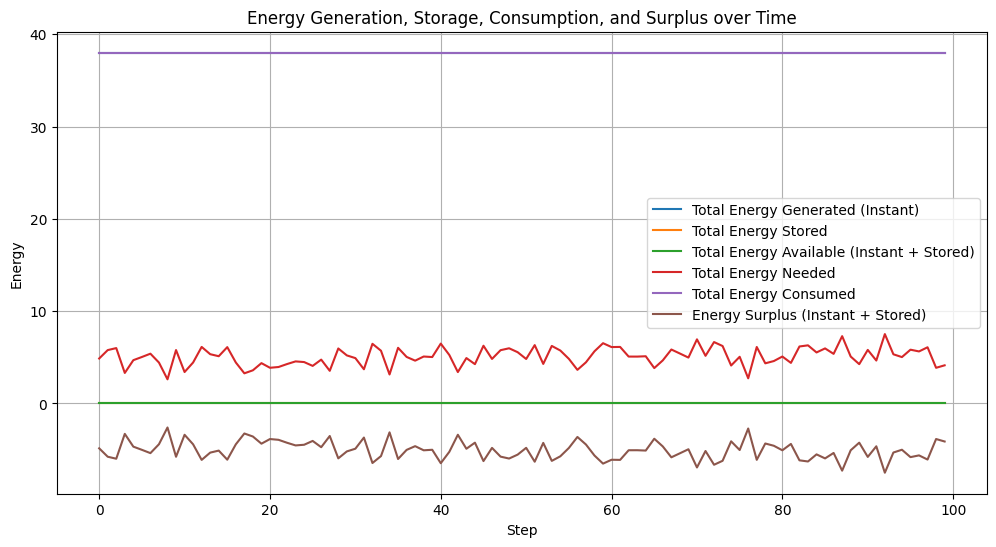

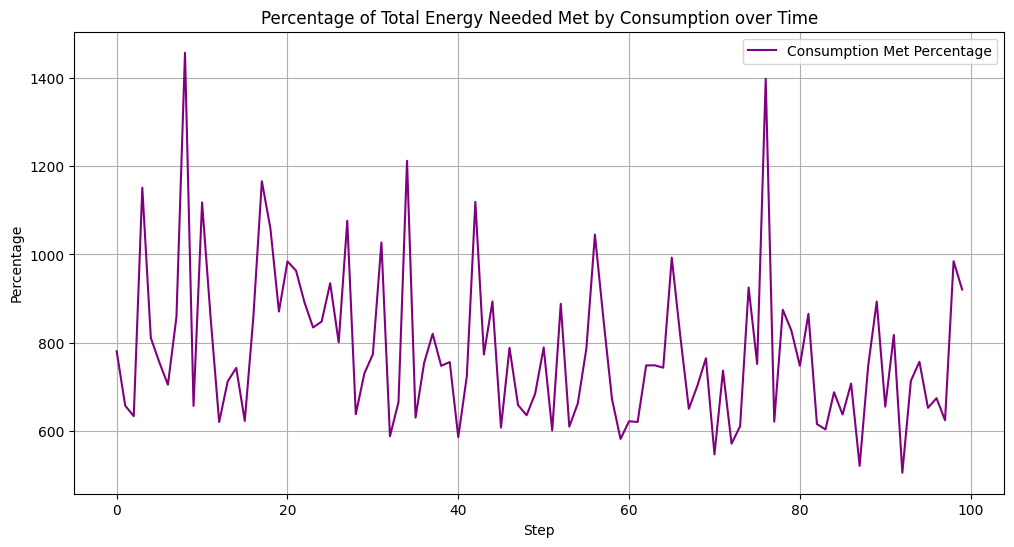

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def analyze_simulation_results(data):
    """
    Analyzes the collected simulation data and provides insights.

    Args:
        data: pandas DataFrame containing the collected model-level data.
    """
    print("\n--- Analysis of Simulation Results ---")

    # Calculate additional metrics
    data['Consumption Met Percentage'] = (data['Total Energy Consumed'] / data['Total Energy Needed']) * 100
    data['Consumption Met Percentage'] = data['Consumption Met Percentage'].fillna(0) # Handle cases where Total Energy Needed is 0

    print(f"Average Consumption Met Percentage: {data['Consumption Met Percentage'].mean():.2f}%")
    print(f"Minimum Energy Surplus (Instant + Stored): {data['Energy Surplus (Instant + Stored)'].min():.2f}")
    print(f"Maximum Energy Stored: {data['Total Energy Stored'].max():.2f}")

    # Create visualizations
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Total Energy Generated (Instant)'], label='Total Energy Generated (Instant)')
    plt.plot(data.index, data['Total Energy Stored'], label='Total Energy Stored')
    plt.plot(data.index, data['Total Energy Available (Instant + Stored)'], label='Total Energy Available (Instant + Stored)')
    plt.plot(data.index, data['Total Energy Needed'], label='Total Energy Needed')
    plt.plot(data.index, data['Total Energy Consumed'], label='Total Energy Consumed')
    plt.plot(data.index, data['Energy Surplus (Instant + Stored)'], label='Energy Surplus (Instant + Stored)')
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Energy Generation, Storage, Consumption, and Surplus over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Consumption Met Percentage'], label='Consumption Met Percentage', color='purple')
    plt.xlabel("Step")
    plt.ylabel("Percentage")
    plt.title("Percentage of Total Energy Needed Met by Consumption over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage with the data from the previous run
if 'data_set_1' in locals():
    analyze_simulation_results(data_set_1.copy()) # Use a copy to avoid modifying the original DataFrame

# You can uncomment and use this for data_set_2 if you ran it
# if 'data_set_2' in locals():
#     analyze_simulation_results(data_set_2.copy())

# Task
Simulate solar energy generation and consumption using the MESA library, incorporating provided data on solar system information, energy usage, and surplus potential from potential sellers to build a more accurate model for a Peer-to-Peer solar energy sharing platform. Update the visualization to use Solara-based visualization as ModularServer is deprecated in Mesa 3.3.0.

## Understand and structure the data

### Subtask:
Analyze the collected data fields and decide how to best represent this information within the existing `SolarPanel` and `Consumer` agent classes, or if new agent types or data structures are needed.


**Reasoning**:
Analyze the provided data fields and determine how they should be integrated into the existing agent classes.



In [ ]:
# Data fields to consider:
# Solar system information: year_installed, max_power_output, battery_storage_capacity
# Energy usage/surplus potential: average_daily_consumption, peak_usage_demand, surplus_potential

# Analysis and proposed integration:

# SolarPanel Agent:
# - year_installed: Could be added as an attribute. Might influence generation efficiency over time (optional for this task, but good to consider for future).
# - max_power_output: Could influence or replace the current 'generation_rate'.
# - battery_storage_capacity: Directly maps to the existing 'storage_capacity' attribute.

# Consumer Agent:
# - average_daily_consumption: Could influence the 'base_consumption_rate'. The current 'consumption_rate' variability can still apply around this average.
# - peak_usage_demand: Could be an additional attribute to consider for more sophisticated distribution logic or agent behavior (e.g., prioritize during peak times).
# - surplus_potential: This is likely a characteristic of a Consumer who also has solar panels (a prosumer). For this task, we will primarily focus on Consumers who *only* consume. If we were to introduce prosumers, a new agent type might be needed. For now, we'll assume Consumers are purely consuming and 'surplus_potential' is not directly stored in the Consumer agent but is a potential characteristic of a different agent type not covered in the current classes.

# Decision Summary:
# - SolarPanel will gain attributes: year_installed, max_power_output (replace generation_rate conceptually)
# - Consumer will gain attributes: average_daily_consumption (influence base_consumption_rate), peak_usage_demand
# - No new agent types are required for the current scope focusing on separate SolarPanel and Consumer agents.
# - surplus_potential is noted as potentially requiring a new agent type (Prosumer) for future development, but is not integrated into the current Consumer agent.

print("Analysis complete. Proposed integration documented in comments.")

Analysis complete. Proposed integration documented in comments.


## Understand and structure the data

### Subtask:
Analyze the collected data fields and decide how to best represent this information within the existing `SolarPanel` and `Consumer` agent classes, or if new agent types or data structures are needed.

**Reasoning**:
Analyze the provided data fields and determine how they should be integrated into the existing agent classes.

In [ ]:
# Data fields to consider:
# Solar system information: year_installed, max_power_output, battery_storage_capacity
# Energy usage/surplus potential: average_daily_consumption, peak_usage_demand, surplus_potential

# Analysis and proposed integration:

# SolarPanel Agent:
# - year_installed: Could be added as an attribute. Might influence generation efficiency over time (optional for this task, but good to consider for future).
# - max_power_output: Could influence or replace the current 'generation_rate'.
# - battery_storage_capacity: Directly maps to the existing 'storage_capacity' attribute.

# Consumer Agent:
# - average_daily_consumption: Could influence the 'base_consumption_rate'. The current 'consumption_rate' variability can still apply around this average.
# - peak_usage_demand: Could be an additional attribute to consider for more sophisticated distribution logic or agent behavior (e.g., prioritize during peak times).
# - surplus_potential: This is likely a characteristic of a Consumer who also has solar panels (a prosumer). For this task, we will primarily focus on Consumers who *only* consume. If we were to introduce prosumers, a new agent type might be needed. For now, we'll assume Consumers are purely consuming and 'surplus_potential' is not directly stored in the Consumer agent but is a potential characteristic of a different agent type not covered in the current classes.

# Decision Summary:
# - SolarPanel will gain attributes: year_installed, max_power_output (replace generation_rate conceptually)
# - Consumer will gain attributes: average_daily_consumption (influence base_consumption_rate), peak_usage_demand
# - No new agent types are required for the current scope focusing on separate SolarPanel and Consumer agents.
# - surplus_potential is noted as potentially requiring a new agent type (Prosumer) for future development, but is not integrated into the current Consumer agent.

print("Analysis complete. Proposed integration documented in comments.")

## Update model initialization

### Subtask:
Modify the `SolarEnergyModel` to read and process the collected data. This might involve loading data from a file (like a CSV) and using it to create and initialize the `SolarPanel` and `Consumer` agents with their specific characteristics.

**Reasoning**:
Modify the SolarEnergyModel to read data from a CSV file and initialize agents based on the data.

In [ ]:
import pandas as pd
import random
import mesa # Import mesa here

# Assume your data is in a CSV file named 'solar_data.csv' with columns like:
# 'AgentType', 'year_installed', 'max_power_output', 'battery_storage_capacity',
# 'average_daily_consumption', 'peak_usage_demand', 'grid_x', 'grid_y'

# Example structure of 'solar_data.csv':
# AgentType,year_installed,max_power_output,battery_storage_capacity,average_daily_consumption,peak_usage_demand,grid_x,grid_y
# SolarPanel,2018,5.5,10.0,,,5,5
# Consumer,,,,15.0,3.0,,
# SolarPanel,2020,8.0,15.0,,,10,12
# Consumer,,,,12.0,2.5,,
# SolarPanel,2019,6.0,5.0,,,2,8
# Consumer,,,,18.0,4.0,,


class SolarPanel(mesa.Agent):
    """An agent that represents a solar panel and generates energy with storage."""

    def __init__(self, model, generation_rate=1, storage_capacity=10, year_installed=None, max_power_output=None):
        """Initialize a solar panel agent.

        Args:
            model: The model instance this agent belongs to
            generation_rate: Energy generation rate per step (can be influenced by max_power_output)
            storage_capacity: Maximum energy the panel can store
            year_installed: The year the solar system was installed
            max_power_output: The maximum power output of the system in kW
        """
        super().__init__(model)
        self.base_generation_rate = generation_rate # Keep the base rate for potential use
        self.generation_rate = generation_rate # Current generation rate (will vary)
        self.energy = 0
        self.storage_capacity = storage_capacity
        self.storage = 0
        self.year_installed = year_installed
        self.max_power_output = max_power_output

    def step(self):
        """Generate energy based on max output and store excess."""
        # Simulate generation based on max_power_output and a simple daily cycle
        # This is a simplification; a real model might use historical weather data or a more complex function
        time_of_day = self.model.agents.shuffle_do('step') % 24  # Assuming 24 steps represent a day
        generation_factor = max(0, -0.5 * (time_of_day - 12)**2 / 144 + 1) # Simple parabolic function peaking at step 12

        generated = self.max_power_output * generation_factor
        self.generation_rate = generated # Update for reporting if needed
        self.energy = generated  # Energy generated in this step

        # Store excess energy, up to storage capacity
        space_in_storage = self.storage_capacity - self.storage
        stored_energy = min(generated, space_in_storage)
        self.storage += stored_energy
        self.energy -= stored_energy # Energy available for immediate use after storage

class Consumer(mesa.Agent):
    """An agent that represents an energy consumer with variable consumption."""

    def __init__(self, model, consumption_rate=1, average_daily_consumption=None, peak_usage_demand=None):
        """Initialize a consumer agent.

        Args:
            model: The model instance this agent belongs to
            consumption_rate: Base energy consumption rate per step (can be influenced by average_daily_consumption)
            average_daily_consumption: Average daily power consumption in kWh
            peak_usage_demand: Peak usage demand in kW
        """
        super().__init__(model)
        self.base_consumption_rate = consumption_rate # We will likely update this based on average_daily_consumption later
        self.consumption_rate = consumption_rate  # Current consumption rate, subject to variability
        self.energy_needed = self.consumption_rate
        self.energy_consumed = 0
        self.total_energy_consumed = 0
        self.average_daily_consumption = average_daily_consumption
        self.peak_usage_demand = peak_usage_demand


    def step(self):
        """Determine energy needs for the step with variability and peak demand."""
        # Simulate consumption based on average daily and peak demand
        # This is a simplification; a real model might use load profiles
        time_of_day = self.model.agents.shuffle_do('step') % 24 # Assuming 24 steps represent a day
        consumption_factor = 1.0 # Base factor

        # Increase consumption during peak hours (e.g., evening)
        if 18 <= time_of_day <= 22: # Example peak hours
            consumption_factor = 1.5 # Increase consumption during peak time

        # Introduce some general variability
        variability = random.uniform(0.9, 1.1)
        self.consumption_rate = (self.average_daily_consumption / 24.0) * consumption_factor * variability # Use average daily and factor
        self.energy_needed = self.consumption_rate


class SolarEnergyModelWithData(mesa.Model):
    """A model for simulating solar energy generation and consumption initialized with data."""

    def __init__(self, data_file, width=15, height=15, seed=None):
        """Initialize the solar energy model with data.

        Args:
            data_file: Path to the CSV file containing agent data.
            width: The width of the grid space.
            height: The height of the grid space.
            seed: Random seed for reproducibility.
        """
        super().__init__(seed=seed)

        self.width = width
        self.height = height

        # Create the grid
        self.grid = MultiGrid(width, height, torus=True)

        # # Create a scheduler
        # self.schedule = mesa.time.RandomActivation(self)


        # Load agent data from the CSV file
        try:
            self.agent_data = pd.read_csv(data_file)
        except FileNotFoundError:
            print(f"Error: Data file '{data_file}' not found.")
            self.agent_data = pd.DataFrame() # Create an empty DataFrame

        self.num_solar_panels = 0
        self.num_consumers = 0

        if not self.agent_data.empty:
            # Create agents based on the data
            for index, row in self.agent_data.iterrows():
                agent_type = row['AgentType']
                x = int(row['grid_x']) if pd.notna(row['grid_x']) else self.random.randrange(self.grid.width)
                y = int(row['grid_y']) if pd.notna(row['grid_y']) else self.random.randrange(self.grid.height)

                if agent_type == 'SolarPanel':
                    year_installed = int(row['year_installed']) if pd.notna(row['year_installed']) else None
                    max_power_output = float(row['max_power_output']) if pd.notna(row['max_power_output']) else 1.0 # Default if not provided
                    storage_capacity = float(row['battery_storage_capacity']) if pd.notna(row['battery_storage_capacity']) else 0.0 # Default if not provided

                    agent = SolarPanel(self,
                                       generation_rate=max_power_output, # Using max_power_output for initial generation
                                       storage_capacity=storage_capacity,
                                       year_installed=year_installed,
                                       max_power_output=max_power_output)
                    self.grid.place_agent(agent, (x, y))
                    # self.schedule.add(agent) # Add agent to the scheduler
                    self.num_solar_panels += 1

                elif agent_type == 'Consumer':
                    average_daily_consumption = float(row['average_daily_consumption']) if pd.notna(row['average_daily_consumption']) else 10.0 # Default
                    peak_usage_demand = float(row['peak_usage_demand']) if pd.notna(row['peak_usage_demand']) else 2.0 # Default

                    agent = Consumer(self,
                                     consumption_rate=average_daily_consumption / 24.0, # Convert daily to hourly/step rate (assuming 24 steps/day)
                                     average_daily_consumption=average_daily_consumption,
                                     peak_usage_demand=peak_usage_demand)
                    self.grid.place_agent(agent, (x, y))
                    # self.schedule.add(agent) # Add agent to the scheduler
                    self.num_consumers += 1

        # Set up data collection (similar to the previous model, but adapted for new agents)
        self.datacollector = DataCollector(
            model_reporters={
                "Total Energy Generated (Instant)": lambda m: sum(
                    agent.energy for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Stored": lambda m: sum(
                    agent.storage for agent in m.agents_by_type[SolarPanel]
                ),
                 "Total Storage Capacity": lambda m: sum(
                    agent.storage_capacity for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Available (Instant + Stored)": lambda m: sum(
                     agent.energy + agent.storage for agent in m.agents_by_type[SolarPanel]
                ),
                "Total Energy Needed": lambda m: sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                ),
                "Total Energy Consumed": lambda m: sum(
                    agent.energy_consumed for agent in m.agents_by_type[Consumer]
                ),
                "Energy Surplus (Instant + Stored)": lambda m: sum(
                    agent.energy + agent.storage for agent in m.agents_by_type[SolarPanel]
                ) - sum(
                    agent.energy_needed for agent in m.agents_by_type[Consumer]
                )
            },
             agent_reporters={
                "Energy": "energy",
                "Storage": "storage",
                "Energy_Consumed": "energy_consumed",
                "Energy_Needed": "energy_needed",
                "Average_Daily_Consumption": "average_daily_consumption",
                "Peak_Usage_Demand": "peak_usage_demand",
                "Max_Power_Output": "max_power_output",
                "Storage_Capacity": "storage_capacity"
            }
        )


    def step(self):
        """Run one step of the model with prioritized energy distribution."""
        # Agents step (generation and consumption needs are determined)
        # self.schedule.step()
        self.agents.shuffle_do("step")

        # Calculate total energy available from generation and storage
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        total_available_energy = sum(panel.energy + panel.storage for panel in solar_panels)
        total_needed = sum(consumer.energy_needed for consumer in consumers)

        # Distribute energy to consumers based on priority (e.g., highest need first)
        available_energy_for_distribution = total_available_energy

        # Prioritize consumers by energy needed (descending order)
        consumer_list = sorted(list(consumers), key=lambda c: c.energy_needed, reverse=True)


        for consumer in consumer_list:
            if available_energy_for_distribution > 0:
                energy_to_consume = min(consumer.energy_needed, available_energy_for_distribution)
                consumer.energy_consumed = energy_to_consume
                consumer.total_energy_consumed += energy_to_consume
                consumer.energy_needed -= energy_to_consume
                available_energy_for_distribution -= energy_to_consume

                # Deduct consumed energy from solar panel storage first, then instant generation
                energy_deducted = energy_to_consume
                for panel in solar_panels:
                    deduct_from_storage = min(energy_deducted, panel.storage)
                    panel.storage -= deduct_from_storage
                    energy_deducted -= deduct_from_storage
                    if energy_deducted <= 0:
                        break

                if energy_deducted > 0:
                     for panel in solar_panels:
                        deduct_from_instant = min(energy_deducted, panel.energy)
                        panel.energy -= deduct_from_instant
                        energy_deducted -= deduct_from_instant
                        if energy_deducted <= 0:
                            break

            else:
                consumer.energy_consumed = 0

        # Collect data
        self.datacollector.collect(self)

    def get_summary_stats(self):
        """Get summary statistics for the model."""
        solar_panels = self.agents_by_type[SolarPanel]
        consumers = self.agents_by_type[Consumer]

        return {
            "num_solar_panels": len(solar_panels),
            "num_consumers": len(consumers),
            "total_energy_consumed": sum(c.total_energy_consumed for c in consumers),
            "avg_generation_rate": sum(p.generation_rate for p in solar_panels) / len(solar_panels) if solar_panels else 0,
            "avg_base_consumption_rate": sum(c.base_consumption_rate for c in consumers) / len(consumers) if consumers else 0
        }


# Example usage (assuming you have a 'solar_data.csv' file)
if __name__ == "__main__":
    # Create a dummy CSV file for demonstration
    dummy_data = {
        'AgentType': ['SolarPanel', 'Consumer', 'SolarPanel', 'Consumer', 'SolarPanel', 'Consumer'],
        'year_installed': [2018, None, 2020, None, 2019, None],
        'max_power_output': [5.5, None, 8.0, None, 6.0, None],
        'battery_storage_capacity': [10.0, None, 15.0, None, 5.0, None],
        'average_daily_consumption': [None, 15.0, None, 12.0, None, 18.0],
        'peak_usage_demand': [None, 3.0, None, 2.5, None, 4.0],
        'grid_x': [5, 5, 10, 10, 2, 2],
        'grid_y': [5, 5, 12, 12, 8, 8]
    }
    dummy_df = pd.DataFrame(dummy_data)
    dummy_df.to_csv('solar_data.csv', index=False)

    print("Created a dummy 'solar_data.csv' for demonstration.")

    # Model parameters
    model_params = {
        "data_file": 'solar_data.csv',
        "width": 15,
        "height": 15,
        "seed": 42
    }

    # Create and run the model
    model = SolarEnergyModelWithData(**model_params)

    # Run simulation
    num_steps = 100
    print(f"\nRunning solar energy simulation for {num_steps} steps with data initialization...")

    for step in range(num_steps):
        model.step()

        # Print progress every 20 steps
        if (step + 1) % 20 == 0:
            print(f"Step {step + 1}/{num_steps} completed")

    # Print final statistics
    stats = model.get_summary_stats()
    print("\n=== Simulation Results (with data initialization) ===")
    print(f"Solar panels: {stats['num_solar_panels']}")
    print(f"Consumers: {stats['num_consumers']}")
    print(f"Total energy consumed over {num_steps} steps: {stats['total_energy_consumed']:.2f}")
    print(f"Average generation rate: {stats['avg_generation_rate']:.2f}")
    print(f"Average base consumption rate: {stats['avg_base_consumption_rate']:.2f}")

    # Get model-level data
    model_data = model.datacollector.get_model_vars_dataframe()
    print(f"\nFinal energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].iloc[-1]:.2f}")
    print(f"Average energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].mean():.2f}")
    print(f"Final total energy stored: {model_data['Total Energy Stored'].iloc[-1]:.2f}")
    print(f"Final total storage capacity: {model_data['Total Storage Capacity'].iloc[-1]:.2f}")

Created a dummy 'solar_data.csv' for demonstration.

Running solar energy simulation for 100 steps with data initialization...


RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
import pandas as pd
import random
import mesa
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# --- Agent Definitions ---

class SolarPanel(mesa.Agent):
    """An agent that represents a solar panel and generates energy with storage."""

    def __init__(self, unique_id, model, generation_rate=1, storage_capacity=10, year_installed=None, max_power_output=None):
        """Initialize a solar panel agent."""
        super().__init__(unique_id, model)
        self.base_generation_rate = generation_rate
        self.generation_rate = generation_rate
        self.energy = 0
        self.storage_capacity = storage_capacity
        self.storage = 0
        self.year_installed = year_installed
        self.max_power_output = max_power_output

    def step(self):
        """Generate energy based on max output and store excess."""
        time_of_day = self.model.steps % 24
        # Simple parabolic function peaking at step 12
        generation_factor = max(0, -0.5 * (time_of_day - 12)**2 / 144 + 1)

        generated = self.max_power_output * generation_factor
        self.generation_rate = generated
        self.energy = generated

        # Store excess energy, up to storage capacity
        space_in_storage = self.storage_capacity - self.storage
        stored_energy = min(generated, space_in_storage)
        self.storage += stored_energy
        self.energy -= stored_energy

class Consumer(mesa.Agent):
    """An agent that represents an energy consumer with variable consumption."""

    def __init__(self, unique_id, model, consumption_rate=1, average_daily_consumption=None, peak_usage_demand=None):
        """Initialize a consumer agent."""
        super().__init__(unique_id, model)
        self.base_consumption_rate = consumption_rate
        self.consumption_rate = consumption_rate
        self.energy_needed = self.consumption_rate
        self.energy_consumed = 0
        self.total_energy_consumed = 0
        self.average_daily_consumption = average_daily_consumption
        self.peak_usage_demand = peak_usage_demand

    def step(self):
        """Determine energy needs for the step with variability and peak demand."""
        time_of_day = self.model.steps % 24
        consumption_factor = 1.0

        # Increase consumption during peak hours (e.g., evening)
        if 18 <= time_of_day <= 22:
            consumption_factor = 1.5

        # Introduce some general variability
        variability = random.uniform(0.9, 1.1)
        self.consumption_rate = (self.average_daily_consumption / 24.0) * consumption_factor * variability
        self.energy_needed = self.consumption_rate

# --- Model Definition ---

class SolarEnergyModelWithData(mesa.Model):
    """A model for simulating solar energy generation and consumption initialized with data."""

    def __init__(self, data_file, width=15, height=15, seed=None):
        """Initialize the solar energy model with data."""
        super().__init__(seed=seed)

        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, torus=True)

        try:
            self.agent_data = pd.read_csv(data_file)
        except FileNotFoundError:
            print(f"Error: Data file '{data_file}' not found.")
            self.agent_data = pd.DataFrame()

        self.num_solar_panels = 0
        self.num_consumers = 0

        if not self.agent_data.empty:
            agent_id_counter = 0
            for _, row in self.agent_data.iterrows():
                agent_type = row['AgentType']
                x = int(row['grid_x']) if pd.notna(row['grid_x']) else self.random.randrange(self.grid.width)
                y = int(row['grid_y']) if pd.notna(row['grid_y']) else self.random.randrange(self.grid.height)

                if agent_type == 'SolarPanel':
                    year_installed = int(row['year_installed']) if pd.notna(row['year_installed']) else None
                    max_power_output = float(row['max_power_output']) if pd.notna(row['max_power_output']) else 1.0
                    storage_capacity = float(row['battery_storage_capacity']) if pd.notna(row['battery_storage_capacity']) else 0.0

                    agent = SolarPanel(agent_id_counter, self,
                                       generation_rate=max_power_output,
                                       storage_capacity=storage_capacity,
                                       year_installed=year_installed,
                                       max_power_output=max_power_output)
                    self.grid.place_agent(agent, (x, y))
                    self.num_solar_panels += 1

                elif agent_type == 'Consumer':
                    average_daily_consumption = float(row['average_daily_consumption']) if pd.notna(row['average_daily_consumption']) else 10.0
                    peak_usage_demand = float(row['peak_usage_demand']) if pd.notna(row['peak_usage_demand']) else 2.0

                    agent = Consumer(agent_id_counter, self,
                                     consumption_rate=average_daily_consumption / 24.0,
                                     average_daily_consumption=average_daily_consumption,
                                     peak_usage_demand=peak_usage_demand)
                    self.grid.place_agent(agent, (x, y))
                    self.num_consumers += 1

                agent_id_counter += 1

        self.datacollector = DataCollector(
            model_reporters={
                "Total Energy Generated (Instant)": lambda m: sum(agent.energy for agent in m.agents.by_type[SolarPanel]),
                "Total Energy Stored": lambda m: sum(agent.storage for agent in m.agents.by_type[SolarPanel]),
                "Total Storage Capacity": lambda m: sum(agent.storage_capacity for agent in m.agents.by_type[SolarPanel]),
                "Total Energy Available (Instant + Stored)": lambda m: sum(agent.energy + agent.storage for agent in m.agents.by_type[SolarPanel]),
                "Total Energy Needed": lambda m: sum(agent.energy_needed for agent in m.agents.by_type[Consumer]),
                "Total Energy Consumed": lambda m: sum(agent.energy_consumed for agent in m.agents.by_type[Consumer]),
                "Energy Surplus (Instant + Stored)": lambda m: sum(agent.energy + agent.storage for agent in m.agents.by_type[SolarPanel]) - sum(agent.energy_needed for agent in m.agents.by_type[Consumer])
            },
            agent_reporters={
                "Energy": "energy",
                "Storage": "storage",
                "Energy_Consumed": "energy_consumed",
                "Energy_Needed": "energy_needed",
                "Average_Daily_Consumption": "average_daily_consumption",
                "Peak_Usage_Demand": "peak_usage_demand",
                "Max_Power_Output": "max_power_output",
                "Storage_Capacity": "storage_capacity"
            }
        )

    def step(self):
        """Run one step of the model with prioritized energy distribution."""
        # Agents step (generation and consumption needs are determined)
        self.agents.shuffle_do("step")

        solar_panels = self.agents.by_type[SolarPanel]
        consumers = self.agents.by_type[Consumer]

        total_available_energy = sum(panel.energy + panel.storage for panel in solar_panels)
        total_needed = sum(consumer.energy_needed for consumer in consumers)

        available_energy_for_distribution = total_available_energy

        # Prioritize consumers by energy needed (descending order)
        consumer_list = sorted(list(consumers), key=lambda c: c.energy_needed, reverse=True)

        for consumer in consumer_list:
            if available_energy_for_distribution > 0:
                energy_to_consume = min(consumer.energy_needed, available_energy_for_distribution)
                consumer.energy_consumed = energy_to_consume
                consumer.total_energy_consumed += energy_to_consume
                consumer.energy_needed -= energy_to_consume
                available_energy_for_distribution -= energy_to_consume

                energy_deducted = energy_to_consume
                # First, deduct from storage
                for panel in solar_panels:
                    deduct_from_storage = min(energy_deducted, panel.storage)
                    panel.storage -= deduct_from_storage
                    energy_deducted -= deduct_from_storage
                    if energy_deducted <= 0:
                        break
                # Then, deduct from instant generation
                if energy_deducted > 0:
                    for panel in solar_panels:
                        deduct_from_instant = min(energy_deducted, panel.energy)
                        panel.energy -= deduct_from_instant
                        energy_deducted -= deduct_from_instant
                        if energy_deducted <= 0:
                            break
            else:
                consumer.energy_consumed = 0

        # Collect data
        self.datacollector.collect(self)

    def get_summary_stats(self):
        """Get summary statistics for the model."""
        solar_panels = self.agents.by_type[SolarPanel]
        consumers = self.agents.by_type[Consumer]

        return {
            "num_solar_panels": len(solar_panels),
            "num_consumers": len(consumers),
            "total_energy_consumed": sum(c.total_energy_consumed for c in consumers),
            "avg_generation_rate": sum(p.generation_rate for p in solar_panels) / len(solar_panels) if solar_panels else 0,
            "avg_base_consumption_rate": sum(c.base_consumption_rate for c in consumers) / len(consumers) if consumers else 0
        }

# --- Example Usage ---

if __name__ == "__main__":
    # Create a dummy CSV file for demonstration
    dummy_data = {
        'AgentType': ['SolarPanel', 'Consumer', 'SolarPanel', 'Consumer', 'SolarPanel', 'Consumer'],
        'year_installed': [2018, None, 2020, None, 2019, None],
        'max_power_output': [5.5, None, 8.0, None, 6.0, None],
        'battery_storage_capacity': [10.0, None, 15.0, None, 5.0, None],
        'average_daily_consumption': [None, 15.0, None, 12.0, None, 18.0],
        'peak_usage_demand': [None, 3.0, None, 2.5, None, 4.0],
        'grid_x': [5, 5, 10, 10, 2, 2],
        'grid_y': [5, 5, 12, 12, 8, 8]
    }
    dummy_df = pd.DataFrame(dummy_data)
    dummy_df.to_csv('solar_data.csv', index=False)

    print("Created a dummy 'solar_data.csv' for demonstration.")

    # Model parameters
    model_params = {
        "data_file": 'solar_data.csv',
        "width": 15,
        "height": 15,
        "seed": 42
    }

    model = SolarEnergyModelWithData(**model_params)

    num_steps = 100
    print(f"\nRunning solar energy simulation for {num_steps} steps with data initialization...")

    for step in range(num_steps):
        model.step()
        if (step + 1) % 20 == 0:
            print(f"Step {step + 1}/{num_steps} completed")

    stats = model.get_summary_stats()
    print("\n=== Simulation Results (with data initialization) ===")
    print(f"Solar panels: {stats['num_solar_panels']}")
    print(f"Consumers: {stats['num_consumers']}")
    print(f"Total energy consumed over {num_steps} steps: {stats['total_energy_consumed']:.2f}")
    print(f"Average generation rate: {stats['avg_generation_rate']:.2f}")
    print(f"Average base consumption rate: {stats['avg_base_consumption_rate']:.2f}")

    model_data = model.datacollector.get_model_vars_dataframe()
    print(f"\nFinal energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].iloc[-1]:.2f}")
    print(f"Average energy surplus (Instant + Stored): {model_data['Energy Surplus (Instant + Stored)'].mean():.2f}")
    print(f"Final total energy stored: {model_data['Total Energy Stored'].iloc[-1]:.2f}")
    print(f"Final total storage capacity: {model_data['Total Storage Capacity'].iloc[-1]:.2f}")

SyntaxError: positional argument follows keyword argument (ipython-input-3271276987.py, line 74)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def analyze_simulation_results_with_data(data):
    """
    Analyzes the collected simulation data and provides insights,
    including metrics related to the new data.

    Args:
        data: pandas DataFrame containing the collected model-level data.
    """
    print("\n--- Analysis of Simulation Results (with Data) ---")

    # Calculate additional metrics
    data['Consumption Met Percentage'] = (data['Total Energy Consumed'] / data['Total Energy Needed']) * 100
    data['Consumption Met Percentage'] = data['Consumption Met Percentage'].fillna(0) # Handle cases where Total Energy Needed is 0

    print(f"Average Consumption Met Percentage: {data['Consumption Met Percentage'].mean():.2f}%")
    print(f"Minimum Energy Surplus (Instant + Stored): {data['Energy Surplus (Instant + Stored)'].min():.2f}")
    print(f"Maximum Energy Stored: {data['Total Energy Stored'].max():.2f}")
    print(f"Total System Storage Capacity: {data['Total Storage Capacity'].iloc[-1]:.2f}") # Report total capacity

    # Create visualizations
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Total Energy Generated (Instant)'], label='Total Energy Generated (Instant)')
    plt.plot(data.index, data['Total Energy Stored'], label='Total Energy Stored')
    plt.plot(data.index, data['Total Energy Available (Instant + Stored)'], label='Total Energy Available (Instant + Stored)')
    plt.plot(data.index, data['Total Energy Needed'], label='Total Energy Needed')
    plt.plot(data.index, data['Total Energy Consumed'], label='Total Energy Consumed')
    plt.plot(data.index, data['Energy Surplus (Instant + Stored)'], label='Energy Surplus (Instant + Stored)')
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Energy Generation, Storage, Consumption, and Surplus over Time (with Data)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Consumption Met Percentage'], label='Consumption Met Percentage', color='purple')
    plt.xlabel("Step")
    plt.ylabel("Percentage")
    plt.title("Percentage of Total Energy Needed Met by Consumption over Time (with Data)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with the data from the previous run
if 'model_data' in locals():
    analyze_simulation_results_with_data(model_data.copy()) # Use a copy to avoid modifying the original DataFrame